# Predicting the Price per Night of Airbnb Properties in Belgium


In [1]:
#!pip install ydata_profiling
#!pip install geopy
#pip install seaborn

In [2]:
import pandas as pd                
import numpy as np                 
import matplotlib.pyplot as plt 
import seaborn as sns
import shap
from ydata_profiling import ProfileReport
import csv
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="my_app")
import pgeocode
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestRegressor   
from sklearn.ensemble import VotingRegressor
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.ensemble import VotingRegressor
from sklearn.feature_selection import RFECV

from scipy.stats.mstats import winsorize


import warnings
warnings.filterwarnings("ignore")

SEED=1

In [3]:
# Set the style of the plots
plt.style.use('seaborn')
plt.rcParams['axes.titlesize'] = 28
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams["figure.figsize"] = (15, 15)
%matplotlib inline


In [4]:
# Read in the data
train_df = pd.read_csv("train.csv", index_col=0, decimal=',')
train_df = train_df.reset_index()
test_df = pd.read_csv("test.csv", index_col=0, decimal=',')
test_df = test_df.reset_index()

## Exploratory data analysis

<ul>We use ProfileReport to generate an overview of all the features and their values. </ul>
<ul>Than we look at missing values for each features.</ul>  
<ul>After that we look at some boxplots to see how the categorical variables behave.</ul> 

In [5]:
profile = ProfileReport(train_df, minimal=True)
profile.to_file(output_file="output.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

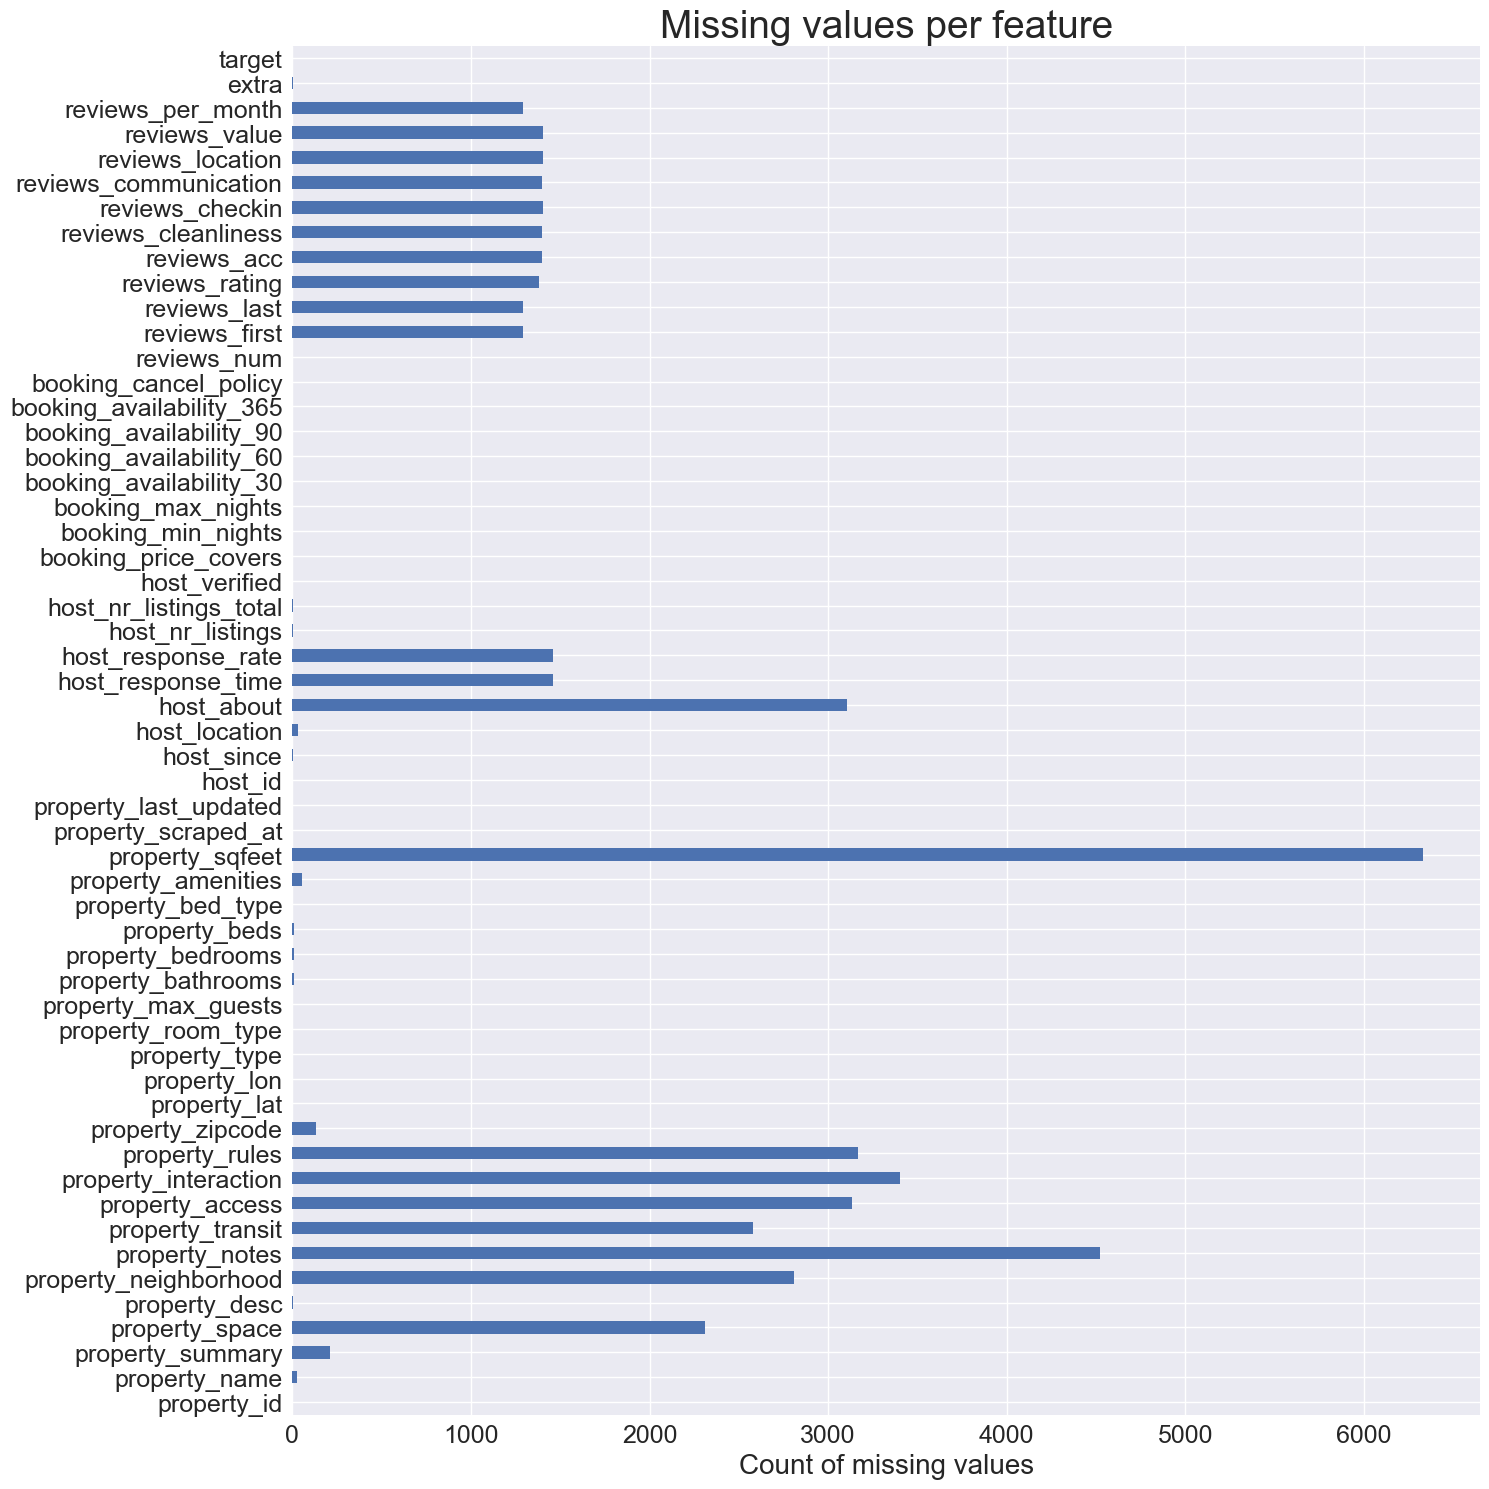

In [4]:
#Checking for missing values
train_df.isnull().sum().plot.barh(width=0.5, ylim=[0, 1000], figsize=(15, 15))
plt.title('Missing values per feature')
plt.xlabel('Count of missing values')
plt.tight_layout()
plt.show()

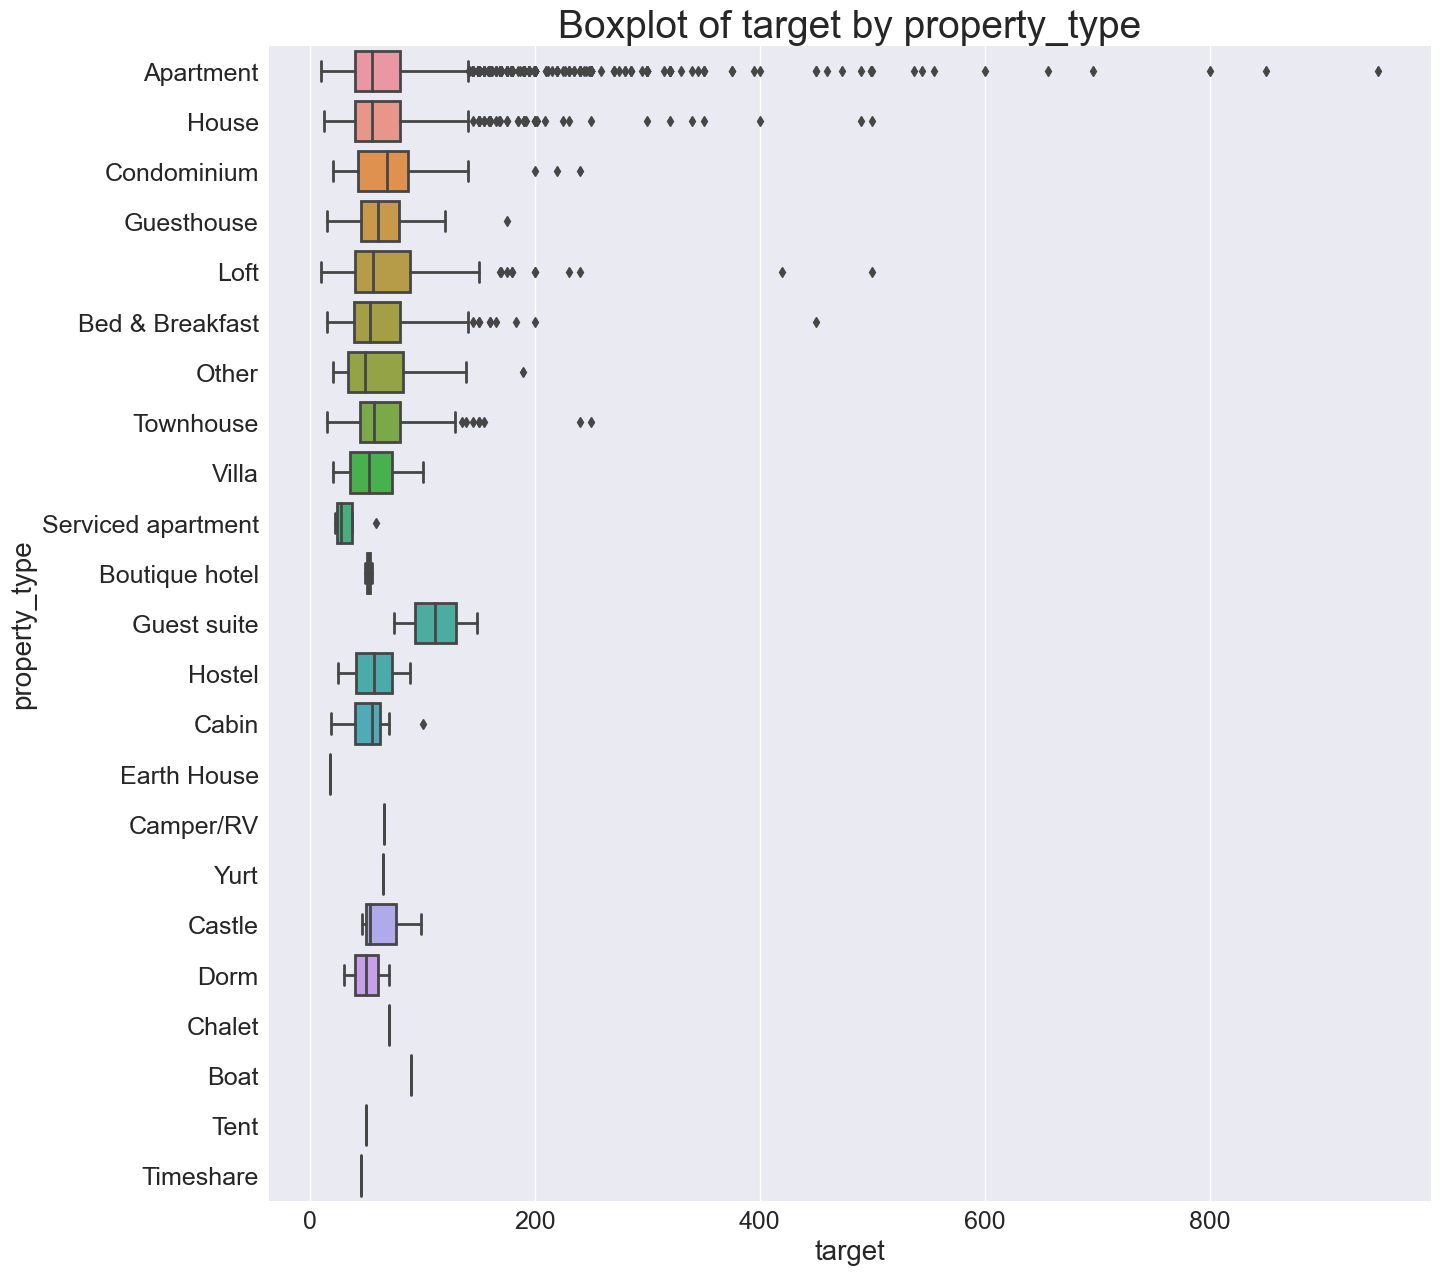

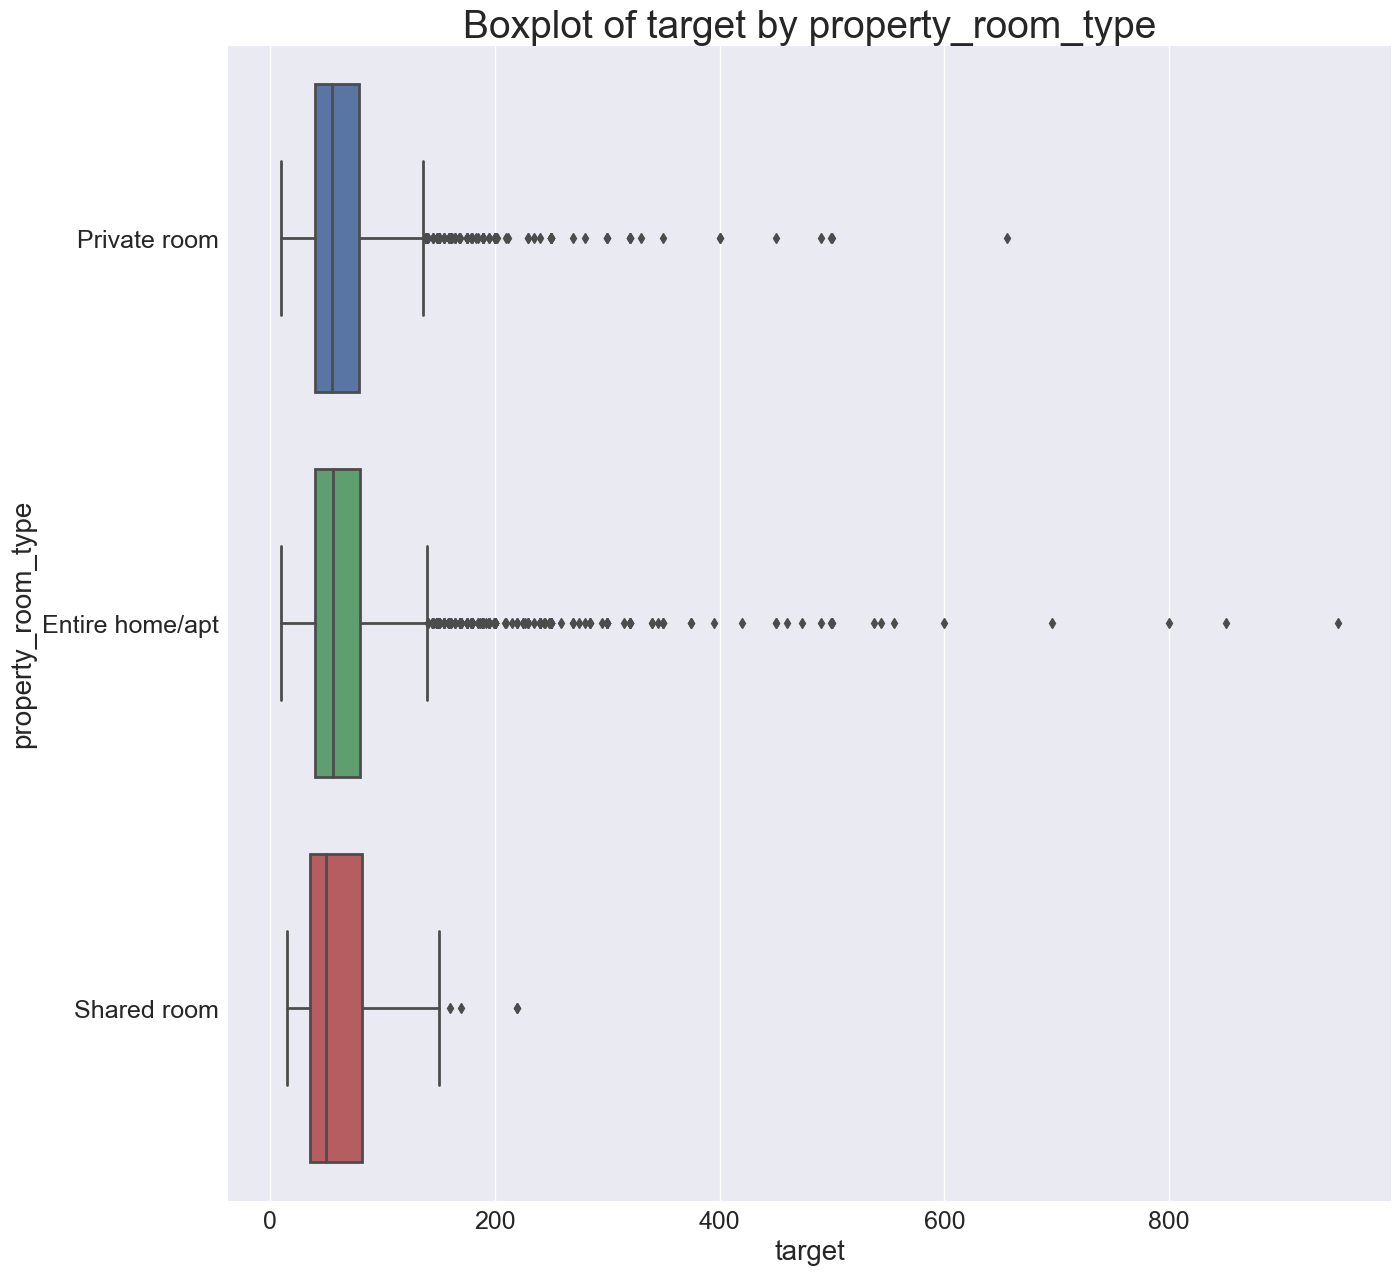

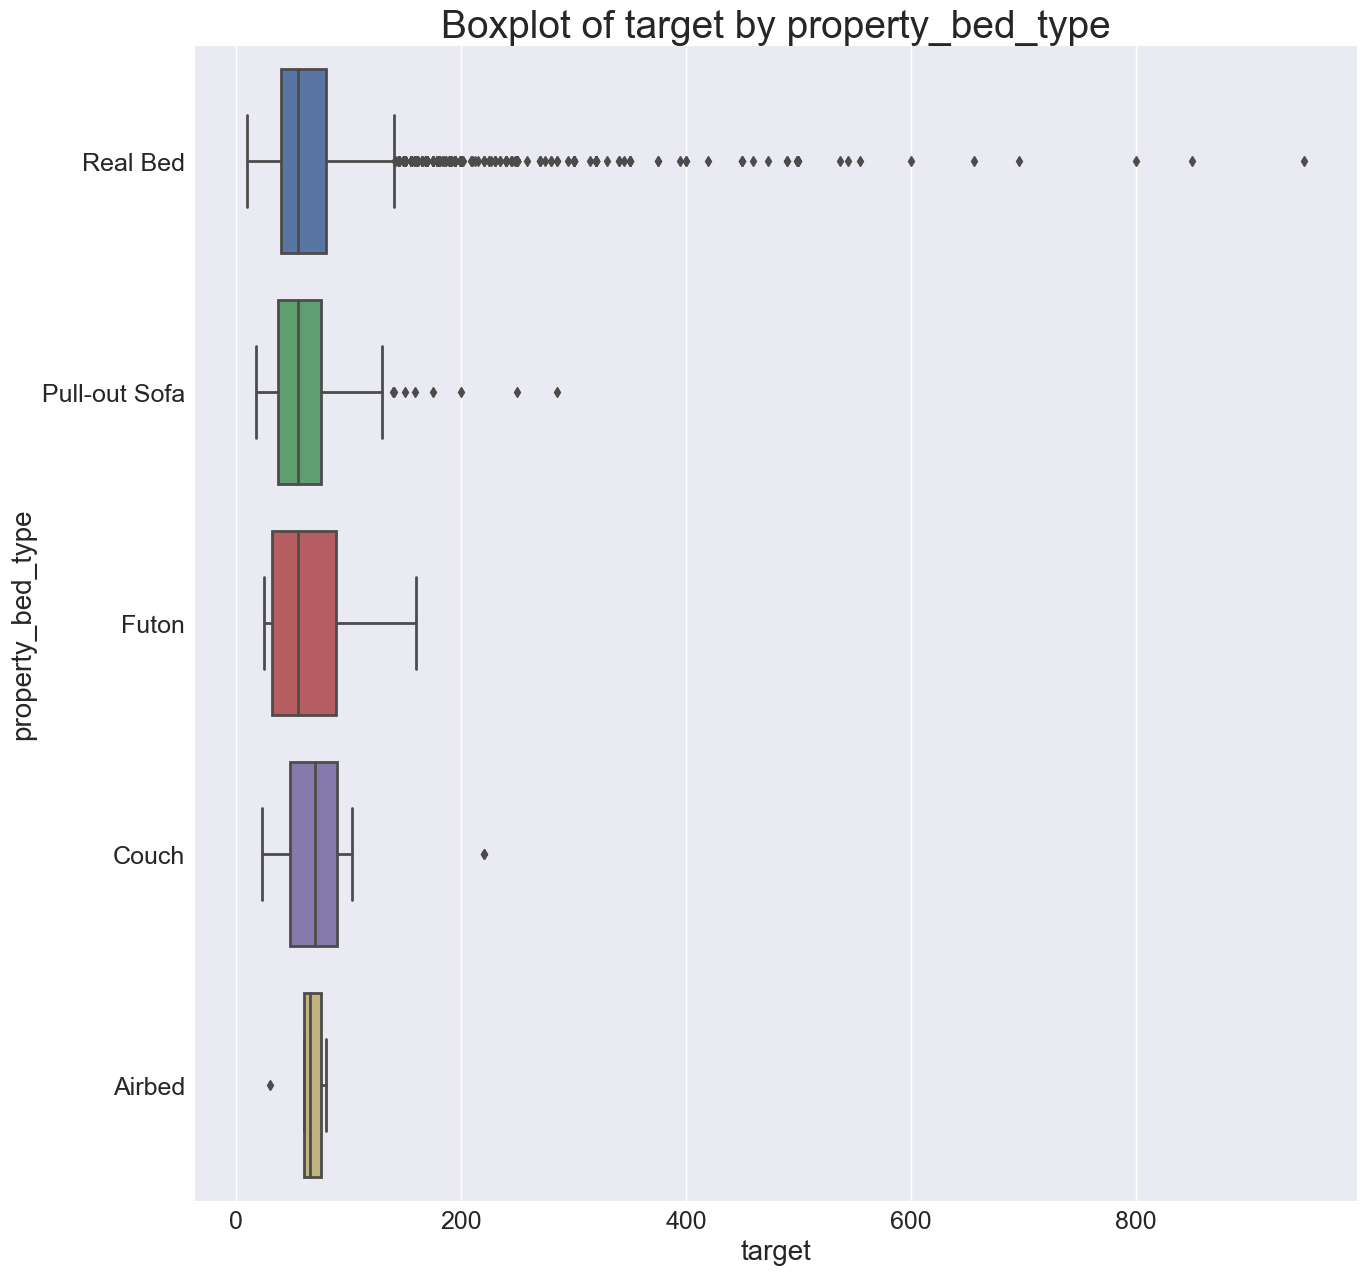

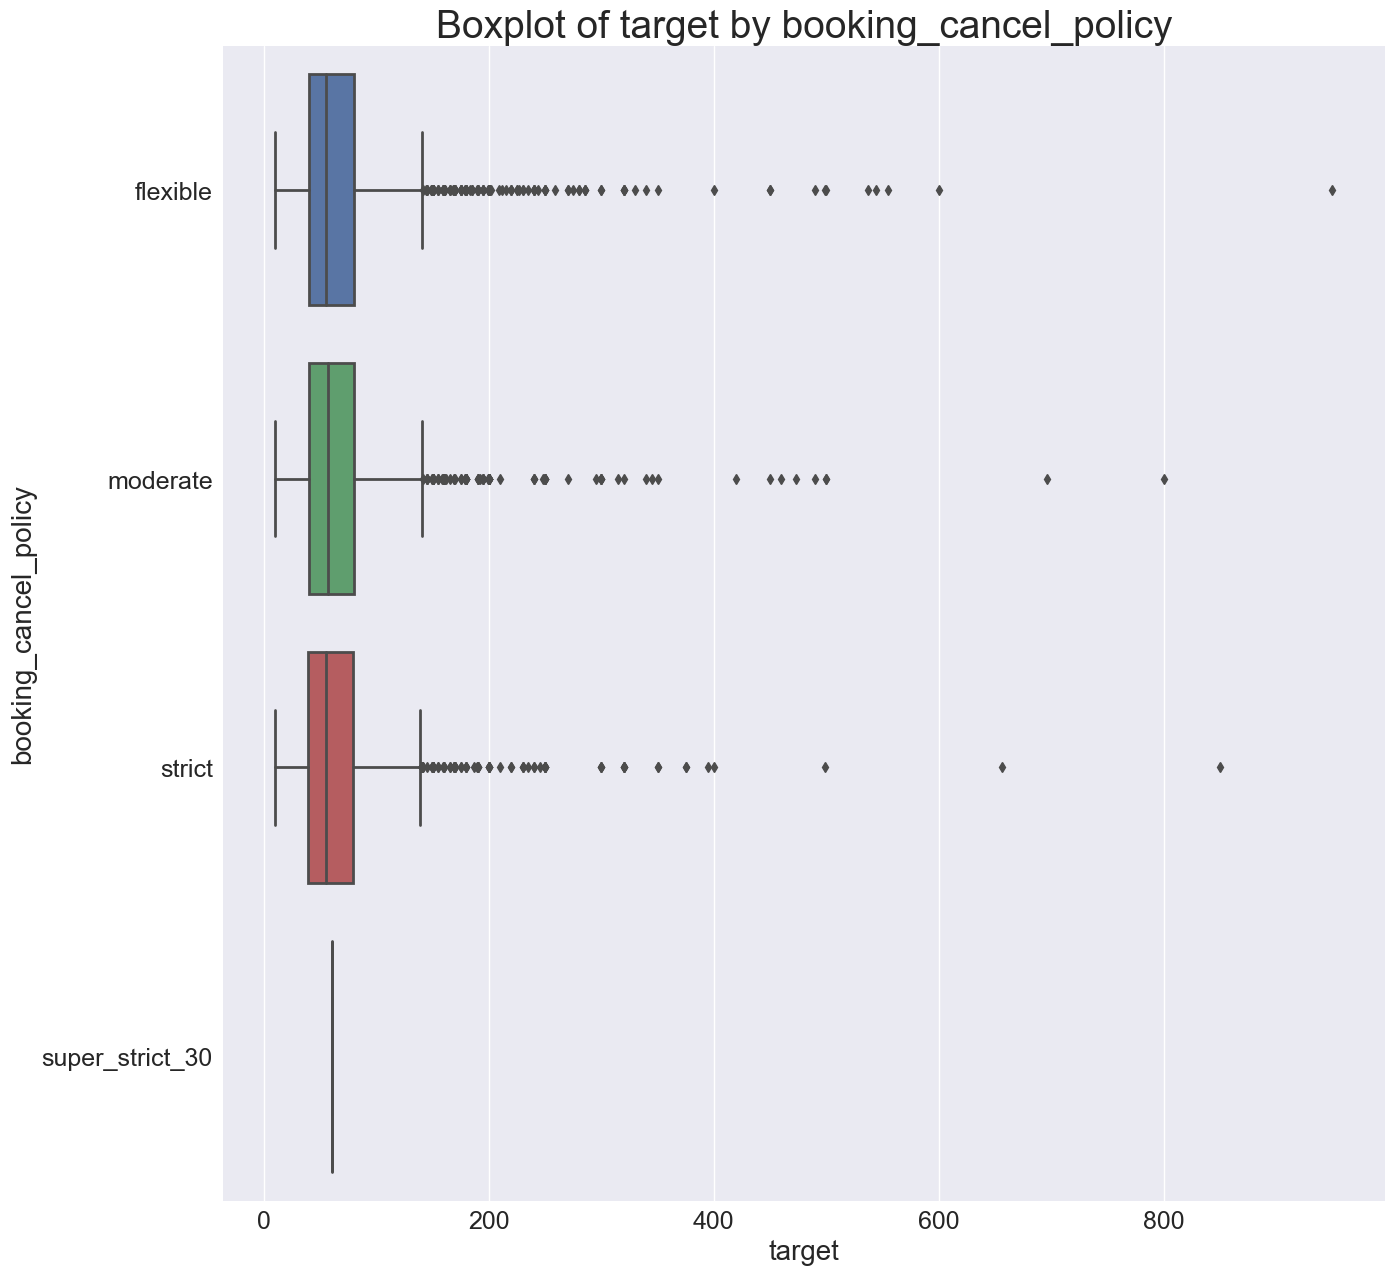

In [12]:
# Boxplot of target by property_type
sns.boxplot(y='property_type', x='target', data=train_df)
plt.title('Boxplot of target by property_type')
plt.show()

# Boxplot of target by property_room_type
sns.boxplot(y='property_room_type', x='target', data=train_df)
plt.title('Boxplot of target by property_room_type')
plt.show()

# Boxplot of target by property_bed_type
sns.boxplot(y='property_bed_type', x='target', data=train_df)
plt.title('Boxplot of target by property_bed_type')
plt.show()

# Boxplot of target by booking_cancel_policy
sns.boxplot(y='booking_cancel_policy', x='target', data=train_df)
plt.title('Boxplot of target by booking_cancel_policy')
plt.show()


## Data Preprocessing

In [5]:
# Calculate the number of amenities, verified, and extra
def add_number_of_columns(data, column_name):
    num_columns = data[column_name].str.count(",") + 1
    data[f"num_{column_name}"] = num_columns
    return data

def handeling_zipcode(data, target_col):
    # Define a function that takes a row of DataFrame and returns the postcode
    def get_postcode(row):
        # Get the latitude and longitude from the row
        lat, lon = row[["property_lat", "property_lon"]]
        # Use parentheses to format the coordinates as input for geolocator.reverse
        location = geolocator.reverse((lat, lon))
        # Get the raw address dictionary from the location object
        address = location.raw.get("address", {})
        # Return the postcode value or None if it doesn't exist
        return address.get("postcode")  
    
    # Fill in missing postcodes using get_postcode function
    empty_rows = data[target_col].isna() | (data[target_col] == "")
    data.loc[empty_rows, target_col] = data[empty_rows].apply(get_postcode, axis=1)
    
    # Remove space from property_zipcode values
    data[target_col] = data[target_col].str.replace(" ", "")
    
    return data

def replace_low_cat(data, target_col, threshold_col):
    # Find the threshold count
    threshold_count = data[target_col].value_counts()[threshold_col]
    property_counts = data[target_col].value_counts()
        # Find the property types that have a lower count than the threshold count
    replace_properties = property_counts[property_counts < threshold_count].index
    # Replace the lower count property types with 'Other'
    data[target_col] = data[target_col].replace(replace_properties, 'Other')
    
    return data

drop_columns = [
        "property_name", "property_summary", "property_space", "property_desc", "property_neighborhood",
        "property_notes", "property_transit", "property_access", "property_interaction", "property_rules",
        "host_about", "host_location", "property_lat", "property_lon", "property_amenities", "extra",
        "host_id", "host_verified", "property_scraped_at", "host_since", "reviews_first", "reviews_last",
        "property_last_updated",'host_response_time','property_id'
    ]

numeric_columns = [
        "property_bathrooms", "property_bedrooms", "property_beds", "host_nr_listings", "host_nr_listings_total",
        "reviews_acc", "reviews_cleanliness", "reviews_checkin", "reviews_communication", "reviews_location",
        "reviews_value", "reviews_per_month","property_zipcode",'host_response_rate','reviews_rating'
    ]
cat_columns = [
    "property_zipcode", "property_type", "property_room_type", "property_bed_type", "booking_cancel_policy"
    ]

def outliers_winsorize(data):
    for col in data.select_dtypes(include=[np.number]).columns:
        data[col] = winsorize(data[col], limits=[0.05, 0.05])
    
    return data

def outliers_winsorize(data):
    for col in data.select_dtypes(include=[np.number]).columns:
        data[col] = winsorize(data[col], limits=[0.05, 0.05])
    
    return data

def impute_missing_values(data, numeric_columns):
    # Impute missing values using IterativeImputer with median strategy
    imputer = IterativeImputer(imputation_order='ascending', initial_strategy='median', max_iter=10, n_nearest_features=None, random_state=0, sample_posterior=False, skip_complete=False, tol=0.001, verbose=0)
    imputer.fit(data[numeric_columns])
    data[numeric_columns] = imputer.transform(data[numeric_columns])

    return data

def impute_missing_property_sqfeet(data):
    df_impute = data[['property_sqfeet']]
    ridge_imputer = IterativeImputer(estimator=Ridge(alpha=10), sample_posterior=True, max_iter=1000, random_state=0)
    df_impute_ridge = pd.DataFrame(ridge_imputer.fit_transform(df_impute), columns=df_impute.columns, index=df_impute.index)
    data[['property_sqfeet']] = df_impute_ridge[['property_sqfeet']]

    return data

def encode_categorical_variables(data, cat_columns):
    encoder = OneHotEncoder(drop="first")
    train_encoded = encoder.fit_transform(data[cat_columns])
    train_encoded = pd.DataFrame.sparse.from_spmatrix(train_encoded, columns=encoder.get_feature_names_out(cat_columns))
    data = pd.concat([data, train_encoded], axis=1)
    data.drop(columns=cat_columns, inplace=True)
    return data


def replace_booking_cancel_policy(data):
    data['booking_cancel_policy'] = data['booking_cancel_policy'].replace('super_strict_30', 'strict')
    return data

def drop_high_corr(data):
    high_corr_columns = ['booking_availability_60', 'host_nr_listings']
    data.drop(high_corr_columns, axis=1, inplace=True)
    return data

# define a function to map zipcodes to city names
def map_zipcode_to_city(data):
    data['property_zipcode'] = data['property_zipcode'].apply(lambda x: 'Brussels' if str(x).startswith('1') else ('Antwerpen' if str(x).startswith('2') else str(x)))
    return data




In [6]:
def process_data(data):
    data = handeling_zipcode(data, "property_zipcode")
    data = add_number_of_columns(data,'property_amenities')
    data = add_number_of_columns(data,'extra')
    data = add_number_of_columns(data,'host_verified')
    data = replace_booking_cancel_policy(data)
    data = data.drop(columns=drop_columns)
    data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric)
    data = impute_missing_property_sqfeet(data)
    data = impute_missing_values(data, numeric_columns)
    data=  replace_low_cat(data, 'property_type', 'Other')
    data = outliers_winsorize(data)
    data = map_zipcode_to_city(data)
    data = encode_categorical_variables(data, cat_columns)
    data = drop_high_corr(data)
    return data

In [7]:
#Processing the trrain and test data
train_df_proc = process_data(train_df)
test_df_proc = process_data(test_df)

## Model selection

### Random Forest model 


Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Best parameters:  {'max_depth': 1, 'min_samples_leaf': 0.3, 'min_samples_split': 0.1, 'n_estimators': 600}
RMSE: 34.27268507475602
MAE: 27.01144274701191


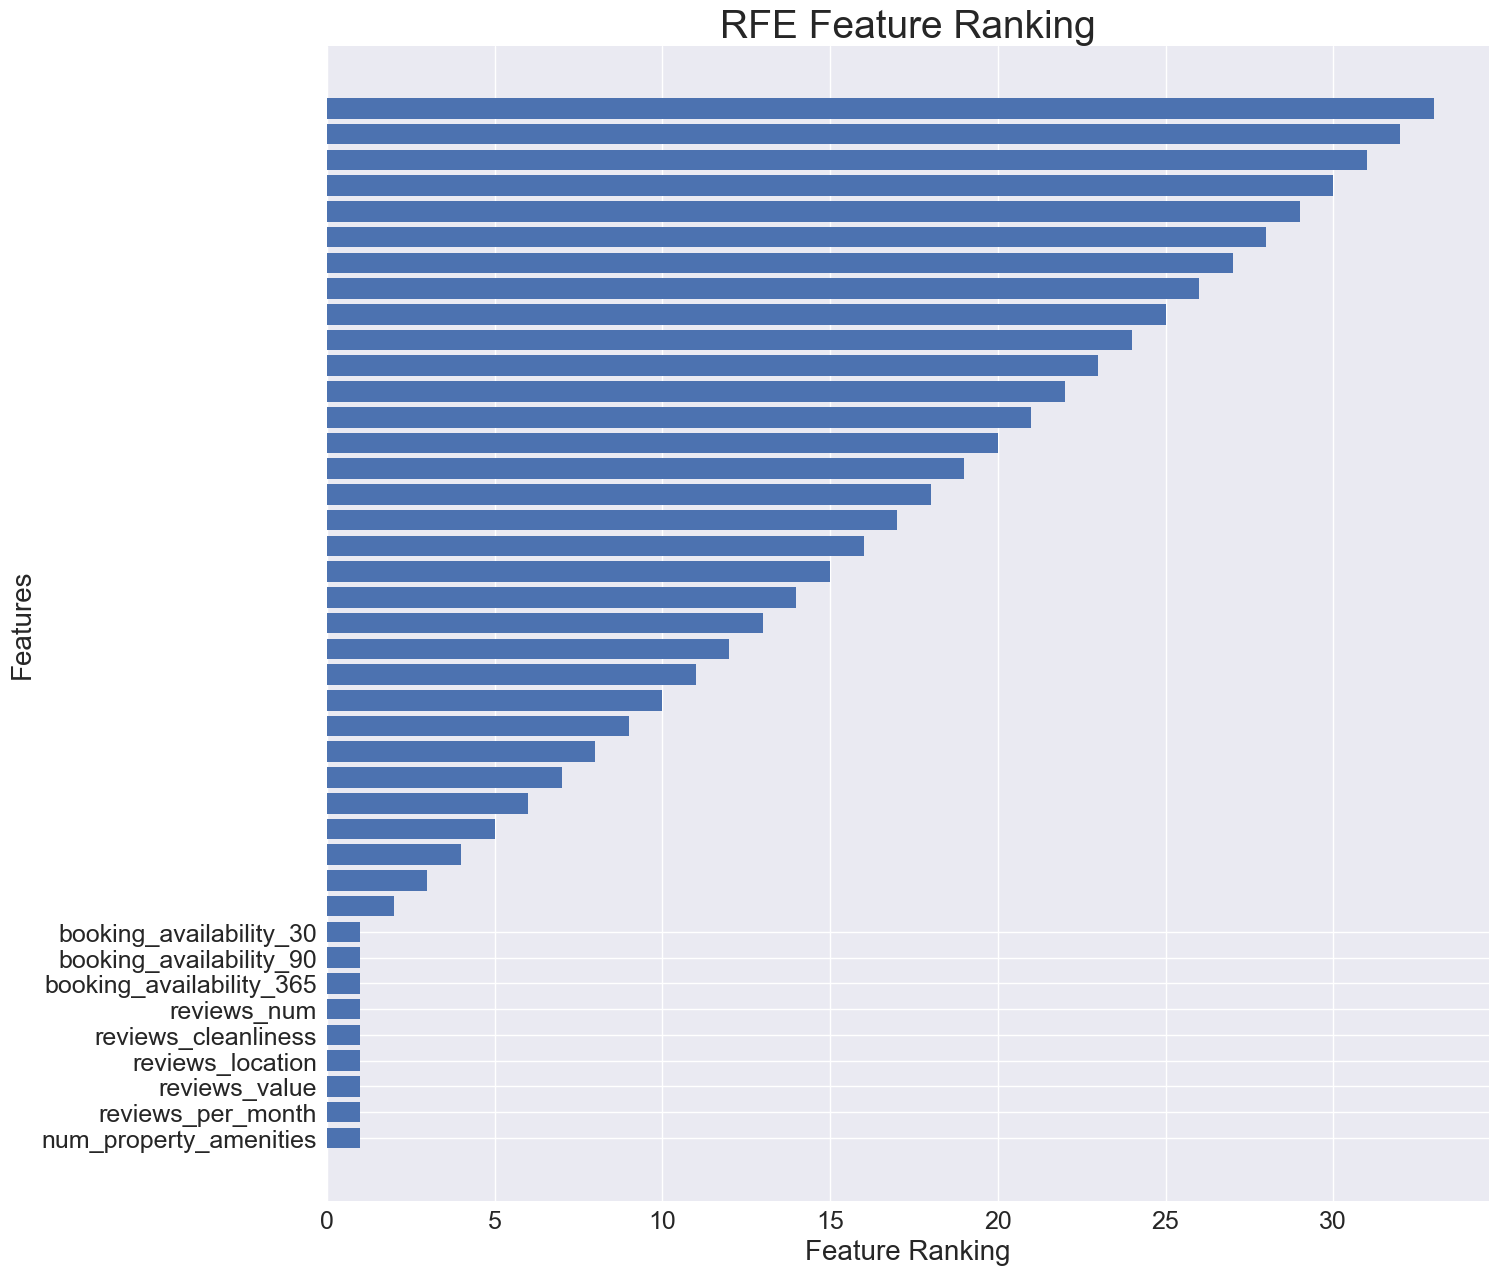

Your predictions are done.


In [8]:
# Setting up the training data
X_train, X_test, y_train, y_test = train_test_split(train_df_proc.drop('target', axis=1), 
                                                    train_df_proc['target'], 
                                                    test_size=0.2, random_state=1)

# Define the random forest regressor
rf = RandomForestRegressor(random_state=SEED)

# Define the hyperparameters to tune
params_rf = {'n_estimators': [450,500,600,700], 
             'max_depth':[1,2,3,4,5], 
             'min_samples_leaf':[0.1,0.2,0.3,0.4,0.5],
             'min_samples_split':[0.1,0.2,0.3,0.4,0.5]}

# Define the grid search with cross-validation
grid_rf = GridSearchCV(estimator=rf, param_grid=params_rf, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
grid_rf.fit(X_train, y_train)

# Get the best estimator from the grid search
best_rf = grid_rf.best_estimator_

# Print the best parameters
print("Best parameters: ", grid_rf.best_params_)

# Define the RFE with cross-validation
rfecv = RFECV(estimator=best_rf, cv=5)

# Fit the RFE on the training data
rfecv.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfecv.support_]

# Use the selected features for both training and test data
X_train_rf = X_train.loc[:, selected_features]
X_test_rf = X_test.loc[:, selected_features]

# Fit the model on the selected features from the training data
best_rf.fit(X_train_rf, y_train)

# Make predictions 
y_pred_rf = best_rf.predict(X_test_rf)

# Getting the RMSE and MAE
RMSE_rf_rfe = np.sqrt(MSE(y_test, y_pred_rf)) 
MAE_rf_rfe = MAE(y_test, y_pred_rf)
print('RMSE:', RMSE_rf_rfe)
print('MAE:', MAE_rf_rfe)

# Sort selected features by ranking
sorted_features = [x for _, x in sorted(zip(rfecv.ranking_, selected_features))]

# Sort ranking values
sorted_ranking = np.sort(rfecv.ranking_)

# Plot the feature importances
plt.figure(figsize=(15, 15))
plt.title('RFE Feature Ranking')
plt.xlabel('Feature Ranking')
plt.ylabel('Features')
plt.barh(range(len(rfecv.ranking_)), sorted_ranking)
plt.yticks(range(len(selected_features)), sorted_features)
plt.show()


# Making predictions
test_df_proc_rf = test_df_proc.loc[:, selected_features]
predictions = best_rf.predict(test_df_proc_rf)
test_df_proc_rf = test_df_proc_rf.reset_index(drop=True)
output_df = pd.DataFrame({'ID': test_df_proc_rf.index+6501, 'PRED': predictions})
output_df.to_csv('predictions_rf_rfe.csv', index=False, header=False, quoting=csv.QUOTE_ALL)
print('Your predictions are done.')


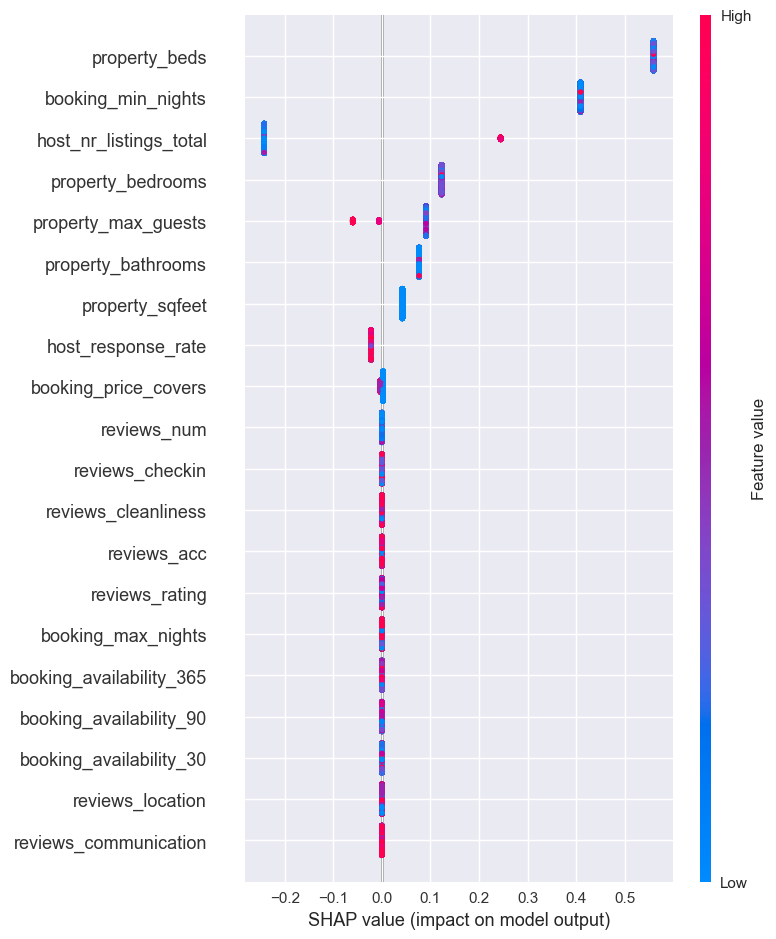

In [9]:
# Create a Tree explainer object which can compute SHAP values for Random Forest
explainer = shap.TreeExplainer(best_rf)

# Compute SHAP values
shap_values = explainer.shap_values(X_train)

# Summarize the SHAP values in a plot
shap.summary_plot(shap_values, X_train)


## Gradient Boosting model

Fitting 5 folds for each of 525 candidates, totalling 2625 fits
Best parameters:  {'learning_rate': 0.1, 'max_depth': 1, 'min_samples_leaf': 0.4, 'n_estimators': 50}
RMSE: 34.245257511780835
MAE: 26.990108342529886


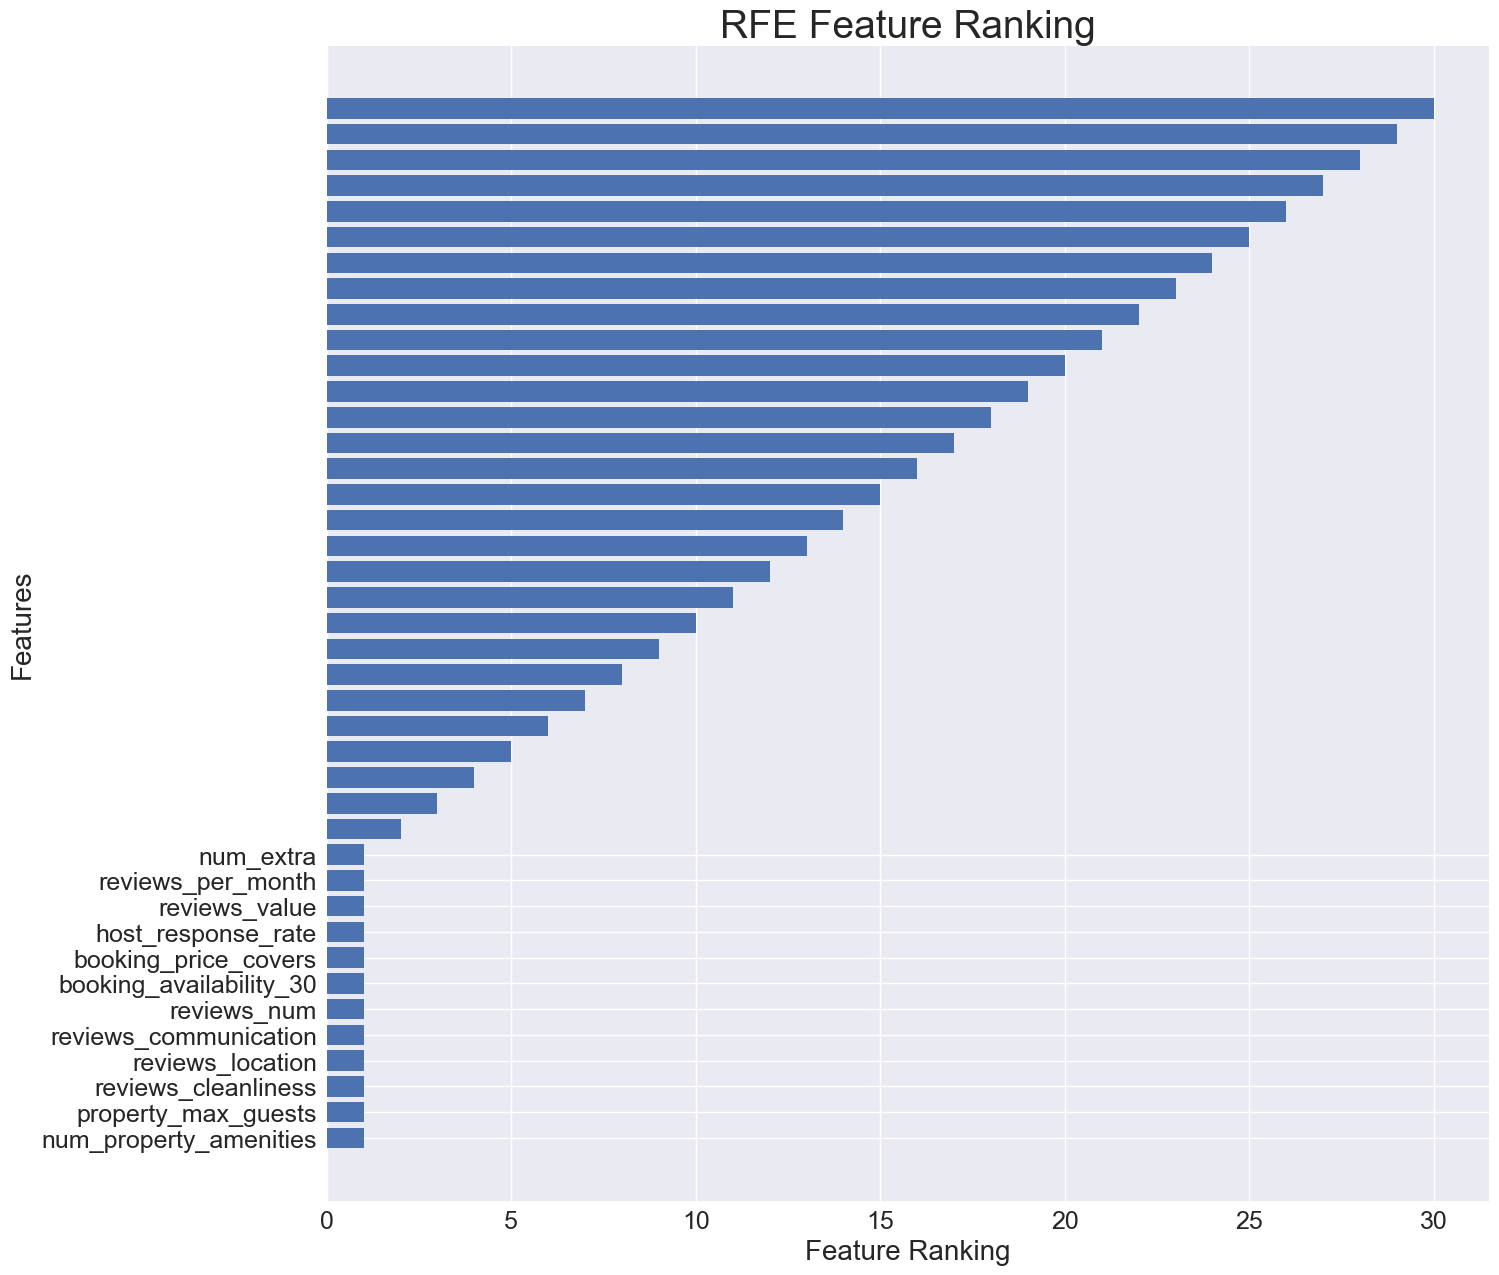

Your predictions are done.


In [10]:
# Setting up the data
X_train, X_test, y_train, y_test = train_test_split(train_df_proc.drop('target', axis=1), 
                                                    train_df_proc['target'], 
                                                    test_size=0.2, random_state=1)

# Define the gradient boosting regressor
gb = GradientBoostingRegressor(random_state=SEED)

# Define the hyperparameters to tune
params_gb = {'n_estimators': [10, 20, 50, 100, 200], 
             'max_depth':[1, 2, 3,4,5], 
             'learning_rate':[0.01, 0.1, 1.0],
             'min_samples_leaf': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]}
# Define the grid search with cross-validation
grid_gb = GridSearchCV(estimator=gb, param_grid=params_gb, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
grid_gb.fit(X_train, y_train)

# Get the best estimator from the grid search
best_gb = grid_gb.best_estimator_

# Print the best parameters
print("Best parameters: ", grid_gb.best_params_)

# Define the RFE with cross-validation
rfecv = RFECV(estimator=best_gb, cv=5)

# Fit the RFE on the training data
rfecv.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfecv.support_]

# Use the selected features for both training and test data
X_train_gb = X_train.loc[:, selected_features]
X_test_gb = X_test.loc[:, selected_features]
best_gb.fit(X_train_gb, y_train)

# Make predictions on the testing data using the selected features and the best estimator
y_pred_gb = best_gb.predict(X_test_gb)

# Getting the RMSE and MAE
RMSE_gb_rfe = np.sqrt(MSE(y_test, y_pred_gb))
MAE_gb_rfe = MAE(y_test, y_pred_gb)
print('RMSE:', RMSE_gb_rfe)
print('MAE:', MAE_gb_rfe)


# Plot the feature importances
sorted_features = [x for _, x in sorted(zip(rfecv.ranking_, selected_features))]
sorted_ranking = np.sort(rfecv.ranking_)
plt.figure(figsize=(15, 15))
plt.title('RFE Feature Ranking')
plt.xlabel('Feature Ranking')
plt.ylabel('Features')
plt.barh(range(len(rfecv.ranking_)), sorted_ranking)
plt.yticks(range(len(selected_features)), sorted_features)
plt.show()

# Making predictions
test_df_proc_gb = test_df_proc.loc[:, selected_features]
predictions = best_gb.predict(test_df_proc_gb)
test_df_proc_gb = test_df_proc_gb.reset_index(drop=True)
output_df = pd.DataFrame({'ID': test_df_proc_gb.index+6501, 'PRED': predictions})
output_df.to_csv('predictions_gb_rfe.csv', index=False, header=False, quoting=csv.QUOTE_ALL)
print('Your predictions are done.')

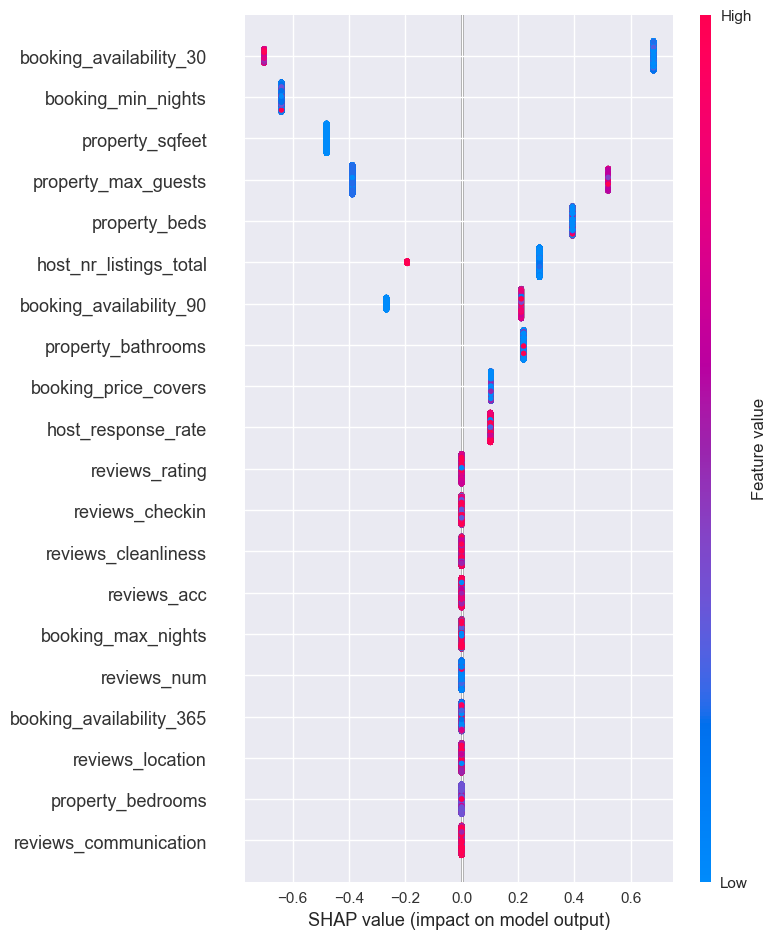

In [11]:
# Create a Tree explainer object which can compute SHAP values for Random Forest
explainer = shap.TreeExplainer(best_gb)

# Compute SHAP values
shap_values = explainer.shap_values(X_train)

# Summarize the SHAP values in a plot
shap.summary_plot(shap_values, X_train)

## Stochastic Gradient Boosting model 

Fitting 5 folds for each of 4800 candidates, totalling 24000 fits
Best parameters:  {'learning_rate': 0.01, 'max_depth': 1, 'max_features': 0.5, 'min_samples_leaf': 0.2, 'n_estimators': 200, 'subsample': 0.5}
RMSE: 34.247273471895035
MAE: 26.997731929298116


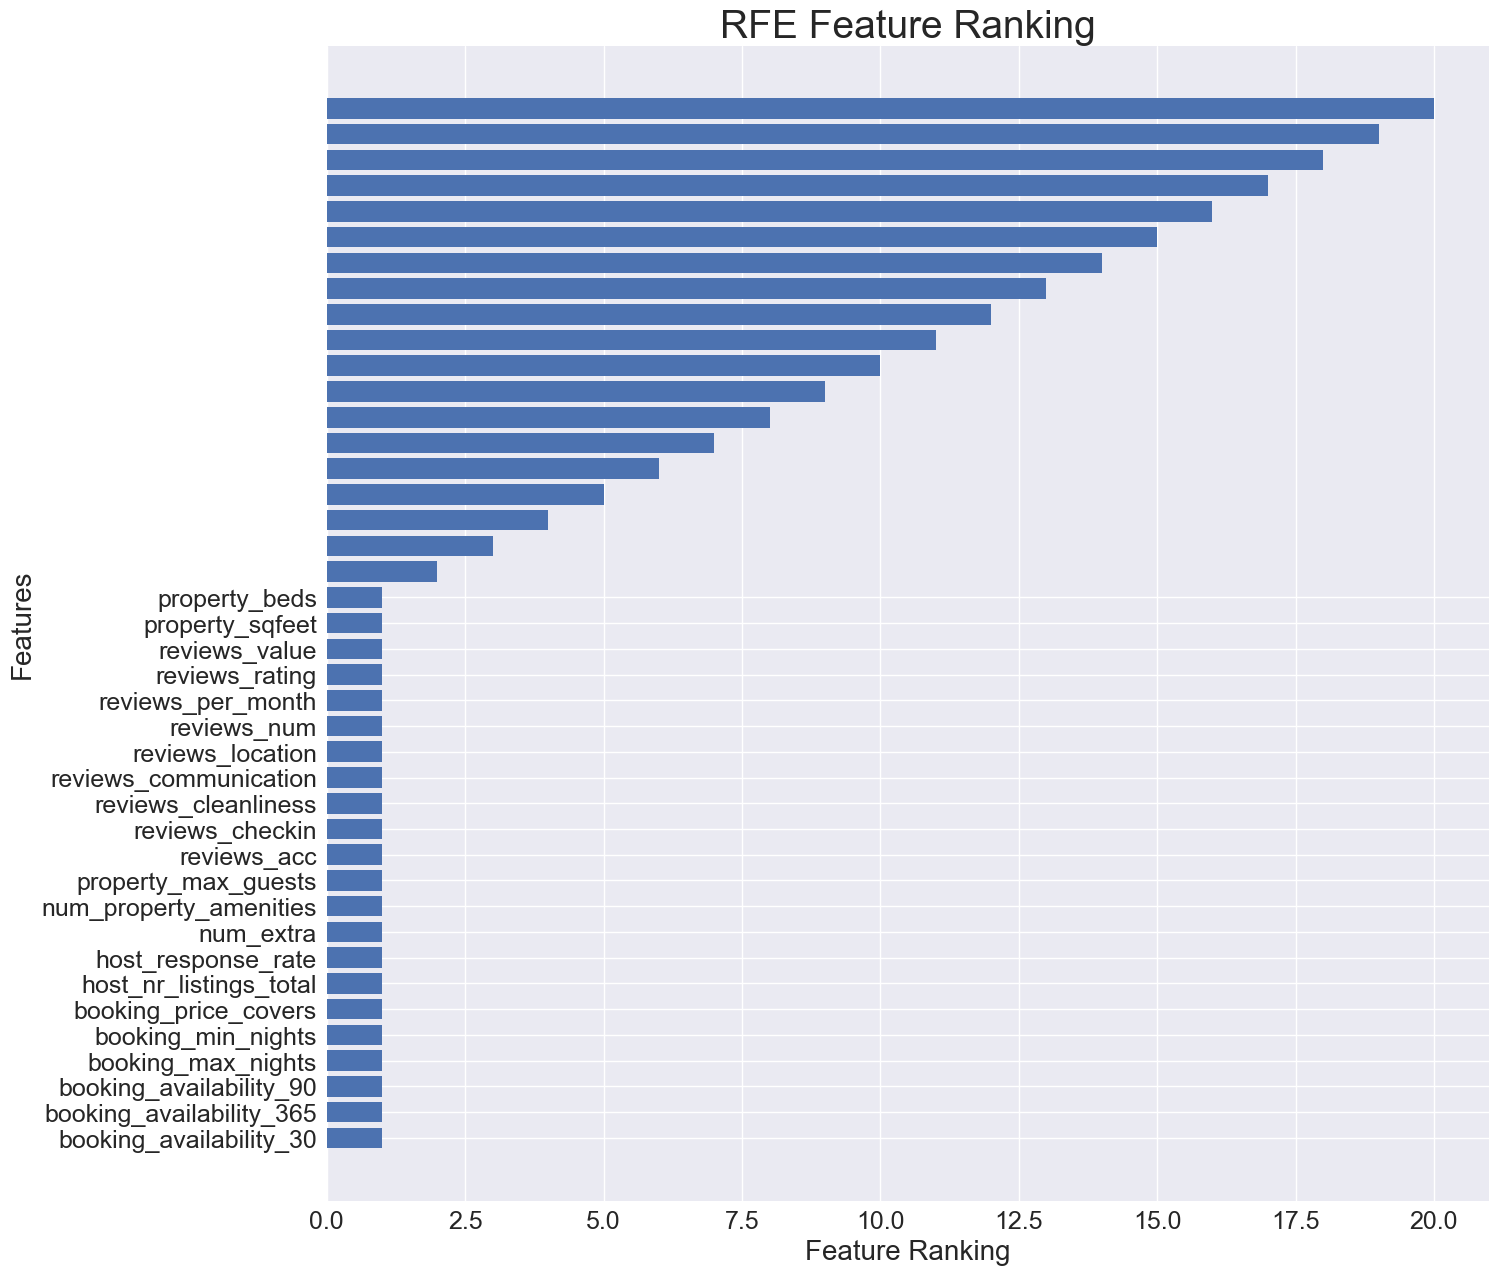

Your predictions are done.


In [12]:
# Setting up the training data
X_train, X_test, y_train, y_test = train_test_split(train_df_proc.drop('target', axis=1), 
                                                    train_df_proc['target'], 
                                                    test_size=0.2, random_state=1)

# Define the gradient boosting regressor
gbr = GradientBoostingRegressor(random_state=SEED)

# Define the hyperparameters to tune
params_gbr = {'n_estimators': [50,100,200,300], 
            'max_depth':[1,2,3,4,5], 
            'min_samples_leaf':[0.2, 0.3, 0.4, 0.5, 0.6],
            'subsample':[0.5,0.6,0.7,0.8],
            'max_features':[0.5,0.6,0.7,0.8],
            'learning_rate':[0.01, 0.1, 1.0],}

# Define the grid search with cross-validation
grid_gbr = GridSearchCV(estimator=gbr, param_grid=params_gbr, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
grid_gbr.fit(X_train, y_train)

# Get the best estimator from the grid search
best_gbr = grid_gbr.best_estimator_

# Print the best parameters
print("Best parameters: ", grid_gbr.best_params_)

# Define the RFE with cross-validation
rfecv = RFECV(estimator=best_gbr, cv=5)

# Fit the RFE on the training data
rfecv.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfecv.support_]

# Use the selected features for both training and test data
X_train_gbr = X_train.loc[:, selected_features]
X_test_gbr = X_test.loc[:, selected_features]

# Fit the model on the selected features from the training data
best_gbr.fit(X_train_gbr, y_train)

# Make predictions on the testing data using the selected features and the best estimator
y_pred_gbr = best_gbr.predict(X_test_gbr)

RMSE_gbr_rfe = np.sqrt(MSE(y_test, y_pred_gbr))
MAE_gbr_rfe = MAE(y_test, y_pred_gbr)
# Print the performance metrics
print('RMSE:', RMSE_gbr_rfe)
print('MAE:', MAE_gbr_rfe)

# Plot the feature importances
sorted_features = [x for _, x in sorted(zip(rfecv.ranking_, selected_features))]
sorted_ranking = np.sort(rfecv.ranking_)
plt.figure(figsize=(15, 15))
plt.title('RFE Feature Ranking')
plt.xlabel('Feature Ranking')
plt.ylabel('Features')
plt.barh(range(len(rfecv.ranking_)), sorted_ranking)
plt.yticks(range(len(selected_features)), sorted_features)
plt.show()

# Making predictions
test_df_proc_gbr = test_df_proc.loc[:, selected_features]
predictions = best_gbr.predict(test_df_proc_gbr)
test_df_proc_gbr = test_df_proc_gbr.reset_index(drop=True)
output_df = pd.DataFrame({'ID': test_df_proc_gbr.index+6501, 'PRED': predictions})
output_df.to_csv('predictions_gbr_rfe.csv', index=False, header=False, quoting=csv.QUOTE_ALL)
print('Your predictions are done.')


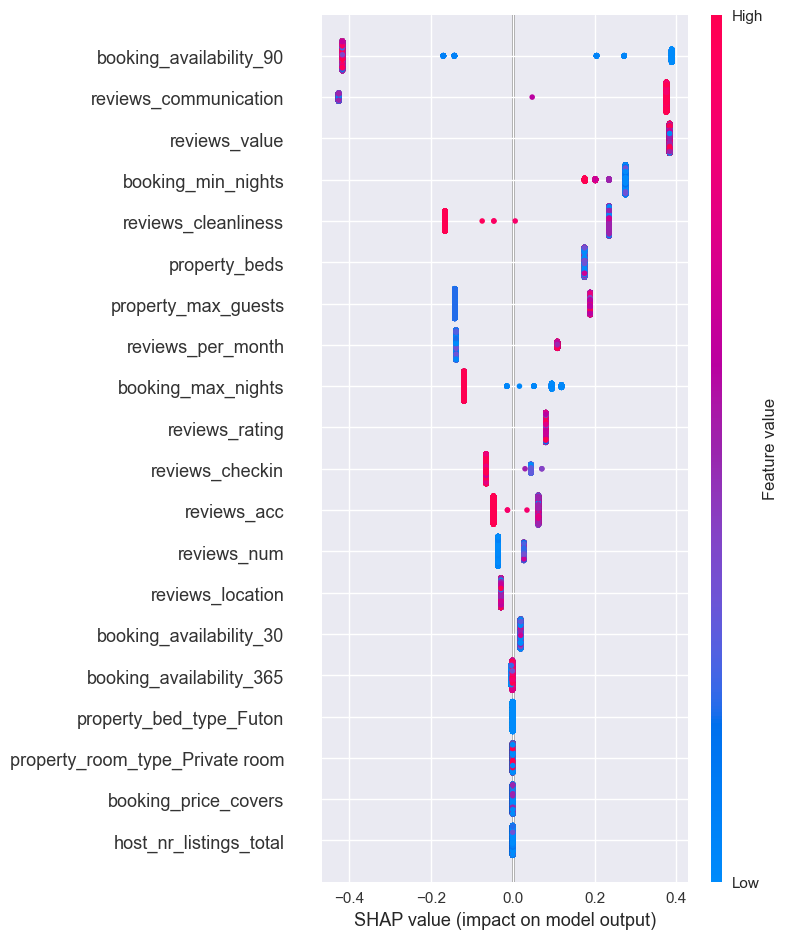

In [13]:
# Create a Tree explainer object which can compute SHAP values for Random Forest
explainer = shap.TreeExplainer(best_gbr)

# Compute SHAP values
shap_values = explainer.shap_values(X_train)

# Summarize the SHAP values in a plot
shap.summary_plot(shap_values, X_train)

## Support vector machine model


In [16]:
svr = SVR(kernel='rbf')

# Hyperparameter tuning
params_svr = {'C': [1, 10, 50, 100, 200],
              'gamma': ['auto','scale', 0.05, 0.1, 1], 
              'epsilon': [10, 20, 30, 40, 50]} 
grid_svr = GridSearchCV(estimator=svr, param_grid=params_svr, scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1)
grid_svr.fit(X_train, y_train)
best_hyperparams_svr = grid_svr.best_params_
print('Best hyperparameters:\n', best_hyperparams_svr)

# Testing RMSE and MAE
best_model_svr = SVR(kernel='rbf', C=best_hyperparams_svr['C'], gamma=best_hyperparams_svr['gamma'], epsilon=best_hyperparams_svr['epsilon'])
best_model_svr.fit(X_train, y_train)
y_pred_svr = best_model_svr.predict(X_test)

# Getting the RMSE and MAE
RMSE_test_svr = MSE(y_test, y_pred_svr) ** (1 / 2)
MAE_test_svr = MAE(y_test, y_pred_svr)
print('Test RMSE of svr: {:.3f}'.format(RMSE_test_svr))
print('Test MAE of svr: {:.3f}'.format(MAE_test_svr))


# Make predictions on new data
predictions = best_model_svr.predict(test_df_proc)
test_df_proc = test_df_proc.reset_index(drop=True)
output_df = pd.DataFrame({'ID': test_df_proc.index+6501, 'PRED': predictions})
output_df.to_csv('predictions_svr.csv', index=False, header=False, quoting=csv.QUOTE_ALL)
print('Your predictions are done.')

Fitting 3 folds for each of 125 candidates, totalling 375 fits
Best hyperparameters:
 {'C': 1, 'epsilon': 30, 'gamma': 0.1}
Test RMSE of svr: 34.225
Test MAE of svr: 27.042
Your predictions are done.


Majorety voting ensamble model

In [17]:
# Create a list of models to include in the ensemble
models = [('Random Forest with RFE', best_rf),
          ('Gradient Boosting with RFE', best_gb), 
          ('Stochastic Gradient Boosting with RFE', best_gbr), 
          ('Support Vector Regression with RFE', best_model_svr)]

# Create the ensemble model
ensemble = VotingRegressor(estimators=models, n_jobs=-1)

# Fit the ensemble model on the training data
ensemble.fit(X_train, y_train)

# Test the ensemble model on the test data
y_pred_ensemble = ensemble.predict(X_test)

# Get the RMSE and MAE
RMSE_test_ensemble = MSE(y_test, y_pred_ensemble) ** (1/2)
MAE_test_ensemble = MAE(y_test, y_pred_ensemble)
print('Test RMSE of ensemble model: {:.3f}'.format(RMSE_test_ensemble))
print('Test MAE of ensemble model: {:.3f}'.format(MAE_test_ensemble))

# Make predictions on new data
predictions = ensemble.predict(test_df_proc)
test_df_proc = test_df_proc.reset_index(drop=True)
output_df = pd.DataFrame({'ID': test_df_proc.index+6501, 'PRED': predictions})
output_df.to_csv('predictions_ensemble.csv', index=False, header=False, quoting=csv.QUOTE_ALL)
print('Your predictions are done.')

Test RMSE of ensemble model: 34.242
Test MAE of ensemble model: 27.006
Your predictions are done.


Compairing RMSE 

In [24]:
RMSE_results = [('Random Forest with RFE-selected features', RMSE_rf_rfe), 
               ('Stochastic Gradient Boosting with RFE-selected features', RMSE_gbr_rfe), 
               ('Gradient Boosting with RFE-selected features', RMSE_gb_rfe),
               ('Ensemble Model with Voting', RMSE_test_ensemble), 
               ('Support Vector Machine', RMSE_test_svr)]

for name, score in sorted(RMSE_results, key=lambda x: x[1]):
    print(f'RMSE of {name}: {score:.3f}')

RMSE of Support Vector Machine: 34.225
RMSE of Gradient Boosting with RFE-selected features: 34.245
RMSE of Ensemble Model with Voting: 34.246
RMSE of Stochastic Gradient Boosting with RFE-selected features: 34.265
RMSE of Random Forest with RFE-selected features: 34.272


SVR gives the lowest RMSE

In [15]:
MAE_results = [('Random Forest with RFE-selected features', MAE_rf_rfe), 
               ('Stochastic Gradient Boosting with RFE-selected features', MAE_gbr_rfe), 
               ('Gradient Boosting with RFE-selected features', MAE_gb_rfe),
               ('Ensemble Model with Voting', MAE_test_ensemble), 
               ('Support Vector Machine', MAE_test_svr)]

for name, score in sorted(MAE_results, key=lambda x: x[1]):
    print(f'MAE of {name}: {score:.3f}')

MAE of Gradient Boosting with RFE-selected features: 26.990
MAE of Stochastic Gradient Boosting with RFE-selected features: 26.999
MAE of Ensemble Model with Voting: 27.006
MAE of Random Forest with RFE-selected features: 27.011
MAE of Support Vector Machine: 27.042


Gradient boosing gives the best results 

### Cool georaphic graph of location and price 

In [34]:
train_df = pd.read_csv("train.csv", index_col=0, decimal=',')

geolocator = Nominatim(user_agent="my_app")

# Define a function that takes a row of DataFrame and returns the postcode
def get_postcode(row):
    # Get the latitude and longitude from the row
    lat, lon = row[["property_lat", "property_lon"]]
    # Use parentheses to format the coordinates as input for geolocator.reverse
    location = geolocator.reverse((lat, lon))
    # Get the raw address dictionary from the location object
    address = location.raw.get("address", {})
    # Return the postcode value or None if it doesn't exist
    return address.get("postcode")

# Fill in missing postcodes using get_postcode function
empty_rows = train_df["property_zipcode"].isna() | (train_df["property_zipcode"] == "")
train_df.loc[empty_rows, "property_zipcode"] = train_df[empty_rows].apply(get_postcode, axis=1)

# Remove any remaining missing or empty postcodes
train_df = train_df[~(train_df["property_zipcode"].isna() | (train_df["property_zipcode"] == ""))]

# Define a function that takes a row of DataFrame and returns the city
def postcode_to_city(postcode):
    nomi = pgeocode.Nominatim('BE')
    location = nomi.query_postal_code(postcode)
    return location.place_name

# Apply the function to the 'property_zipcode' column of train_df
train_df['city'] = train_df['property_zipcode'].apply(postcode_to_city)
train_df['city'] = train_df['city'].replace('Ixelles', 'Bruxelles')

train_df["property_lat"] = pd.to_numeric(train_df["property_lat"], errors="coerce")
train_df["property_lon"] = pd.to_numeric(train_df["property_lon"], errors="coerce")


import plotly.express as px
import numpy as np
import pandas as pd

def create_map(cities, data):
    price_view = lambda x: 'price: ' + str(round(x, 2))

    df_list = []
    for city in cities:
        if city in {'Bruxelles', 'Antwerp'}:
            fraction = 1
        else:
            fraction = 1
        df_temp = data[data['city'] == city].sample(frac=fraction,random_state=101)
        df_temp['target'] = np.round(df_temp['target'], 2)
        df_list.append(df_temp)

    df_concat = pd.concat(df_list)

    fig = px.scatter_mapbox(df_concat, 
                            lat='property_lat', 
                            lon='property_lon', 
                            hover_data=["target", "city"],
                            color='target', 
                            zoom=10)
    
    fig.update_layout(
            title = f'Airbnb prices in {", ".join(cities)}',
            geo_scope='europe',
            width=1000, 
            height=600,
            mapbox_style="white-bg",
            mapbox_layers=[{
                 "below": 'traces',
                 "sourcetype": "raster",
                 "sourceattribution": "OpenStreetMap",
                 "source": ["https://a.tile.openstreetmap.org/{z}/{x}/{y}.png",
                            "https://b.tile.openstreetmap.org/{z}/{x}/{y}.png",
                            "https://c.tile.openstreetmap.org/{z}/{x}/{y}.png"]
              }]
    )
    #fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    #fig.update_geos(fitbounds="locations")
    fig.show()

create_map(['Antwerpen', 'Berchem', 'Bruxelles', 'Etterbeek', 'Forest', 'Laeken', 'Neder-Over-Heembeek', 'Saint-Gilles', 'Saint-Josse-Ten-Noode', 'Schaerbeek', 'Uccle'], train_df)



### Code to get the correlation of all the columns

In [37]:
train_df = pd.read_csv("train.csv", index_col=0, decimal=',')
train_df = train_df.reset_index()

# Define a function named process_train_data that takes a single argument called data
def process_data_corr(data):
    # Call a function add_number_of_amenities to add a new column to the data indicating the number of amenities associated with each row
    data = handeling_zipcode(data, "property_zipcode")
    data = add_number_of_columns(data,'property_amenities')
    data = add_number_of_columns(data,'extra')
    data = add_number_of_columns(data,'host_verified')
    data = replace_booking_cancel_policy(data)
    data = data.drop(columns=drop_columns)
    data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric)
    data = impute_missing_property_sqfeet(data)
    data = impute_missing_values(data, numeric_columns)
    data=  replace_low_cat(data, 'property_type', 'Other')
    data = outliers_winsorize(data)
    data = encode_categorical_variables(data, cat_columns)
    return data

train_df_corr= process_data_corr(train_df)

# Compute the correlation matrix
corr = train_df_corr.corr()

# Filter correlations greater than 0.8
high_corr = corr[abs(corr) >= 0.8]

# Plot the heatmap
plt.figure(figsize=(25,25))
sns.heatmap(high_corr, cmap='coolwarm', annot=True)
plt.show()


# Calculate the correlation matrix
corr = train_df_proc.corr()

# Get the highly correlated columns
high_corr_cols = np.where(np.abs(corr) >= 0.8)

# Convert the indices to a set of tuples
high_corr_cols = {(corr.index[x], corr.columns[y]) for x, y in zip(*high_corr_cols) if x != y}

# Print the highly correlated columns
print(high_corr_cols)




{('booking_availability_90', 'booking_availability_30'), ('booking_availability_30', 'booking_availability_90'), ('property_bed_type_Pull-out Sofa', 'property_bed_type_Real Bed'), ('property_bed_type_Real Bed', 'property_bed_type_Pull-out Sofa')}
